OpenPose without background videos as input

In [11]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
# PATH = f"../../../datasets/openpose_output/openpose_{'' if BACKGROUND else 'no_'}back"
PATH = "/home/wins054/Documents/Khoa/Violence-Detection-With-Human-Skeletons/RWF-2000/openpose_gamma"




In [23]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# # Clear session
# K.clear_session()


# import gc
# del model
# gc.collect()


0

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(os.environ.get('TF_FORCE_GPU_ALLOW_GROWTH'))  # Should print 'true'


true


In [4]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Enable memory growth on the single GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Ensure incremental memory allocation
        print(f"Memory growth enabled for: {gpus[0]}")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected.")


Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Set seed

In [6]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [8]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import cv2
import tensorflow as tf
import gc

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

def process_single_video(video_ID: str, video_label: dict, frames_idx: set, video_width: int, video_height: int, 
                         video_channels: int, dtype, normalize: bool):
    """Process a single video file."""
    cap = cv2.VideoCapture(video_ID)
    frames = []
    index = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if index in frames_idx:
            frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
            if normalize:
                frame /= 255.0
            frames.append(frame)
        index += 1
    cap.release()
    video_data = np.array(frames)
    label = video_label[video_ID]
    return video_data, label

def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, 
                video_height: int = VIDEO_HEIGHT, video_channels: int = N_CHANNELS, dtype=np.float32, normalize: bool = False) -> tuple:
    """Load videos using multithreading."""
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))
    
    # Use ThreadPoolExecutor to parallelize video processing
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_single_video, video_ID, video_labels, frames_idx, video_width, video_height, 
                                   video_channels, dtype, normalize) for video_ID in video_IDs]
        for i, future in enumerate(futures):
            video_data, label = future.result()
            videos[i,] = video_data
            labels[i] = label

    return videos, labels

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, 
                 video_height: int = VIDEO_HEIGHT, video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, 
                 dtype=np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx * self.batch_size:(idx + 1) * self.batch_size]
        return load_videos(batch_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, 
                           self.video_channels, self.dtype, self.normalize)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        gc.collect()


## Videos to load

In [9]:
import glob

train_video_IDs = glob.glob(f"{PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=24)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=24)

# ConvLSTM

In [17]:
inputs = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 100, 100,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 98, 98, 32)     │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 96, 96, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,489 (201.13 KB)

 Trainable params: 51,489 (201.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2)

/home/wins054/anaconda3/envs/violence-detection-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1734090856.099323 1138357 service.cc:148] XLA service 0x640bc37ddba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734090856.099362 1138357 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-13 19:54:16.217849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734090856.584709 1138357 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734090858.695482 1138357 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 - 47s - 723ms/step - accuracy: 0.5494 - loss: 0.6905 - val_accuracy: 0.6927 - val_loss: 0.6762
Epoch 2/30
65/65 - 41s - 635ms/step - accuracy: 0.6218 - loss: 0.6577 - val_accuracy: 0.7005 - val_loss: 0.5781
Epoch 3/30
65/65 - 42s - 644ms/step - accuracy: 0.6782 - loss: 0.6024 - val_accuracy: 0.7682 - val_loss: 0.5024
Epoch 4/30
65/65 - 41s - 632ms/step - accuracy: 0.7154 - loss: 0.5427 - val_accuracy: 0.7917 - val_loss: 0.4535
Epoch 5/30
65/65 - 41s - 633ms/step - accuracy: 0.7545 - loss: 0.5065 - val_accuracy: 0.7891 - val_loss: 0.4450
Epoch 6/30
65/65 - 42s - 640ms/step - accuracy: 0.7647 - loss: 0.4879 - val_accuracy: 0.8281 - val_loss: 0.4104
Epoch 7/30
65/65 - 42s - 645ms/step - accuracy: 0.7673 - loss: 0.4745 - val_accuracy: 0.7448 - val_loss: 0.5071
Epoch 8/30
65/65 - 41s - 629ms/step - accuracy: 0.7788 - loss: 0.4773 - val_accuracy: 0.8021 - val_loss: 0.4278
Epoch 9/30
65/65 - 41s - 631ms/step - accuracy: 0.7942 - loss: 0.4553 - val_accuracy: 0.8125 - val_loss: 0.4191
Epo

In [10]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2)

Epoch 1/30


2022-05-05 15:19:47.658558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-05-05 15:19:48.725938: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-05 15:19:48.727588: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-05-05 15:19:48.727618: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-05 15:19:48.727738: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

160/160 - 210s - loss: 0.6919 - accuracy: 0.5206 - val_loss: 0.6819 - val_accuracy: 0.6400 - 210s/epoch - 1s/step
Epoch 2/30
160/160 - 206s - loss: 0.5965 - accuracy: 0.6850 - val_loss: 0.5086 - val_accuracy: 0.7425 - 206s/epoch - 1s/step
Epoch 3/30
160/160 - 205s - loss: 0.5288 - accuracy: 0.7387 - val_loss: 0.4894 - val_accuracy: 0.7600 - 205s/epoch - 1s/step
Epoch 4/30
160/160 - 204s - loss: 0.4983 - accuracy: 0.7563 - val_loss: 0.4516 - val_accuracy: 0.7875 - 204s/epoch - 1s/step
Epoch 5/30
160/160 - 205s - loss: 0.4701 - accuracy: 0.7856 - val_loss: 0.4329 - val_accuracy: 0.7950 - 205s/epoch - 1s/step
Epoch 6/30
160/160 - 205s - loss: 0.4315 - accuracy: 0.8062 - val_loss: 0.4047 - val_accuracy: 0.8225 - 205s/epoch - 1s/step
Epoch 7/30
160/160 - 206s - loss: 0.4119 - accuracy: 0.8225 - val_loss: 0.3884 - val_accuracy: 0.8325 - 206s/epoch - 1s/step
Epoch 9/30
160/160 - 206s - loss: 0.4165 - accuracy: 0.8169 - val_loss: 0.4096 - val_accuracy: 0.8200 - 206s/epoch - 1s/step
Epoch 10/30

# Reproduce Model Performance

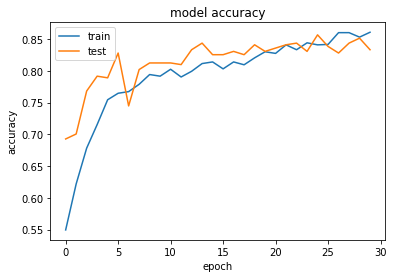

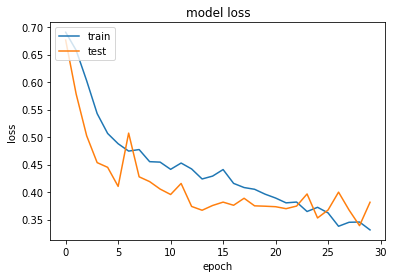

In [19]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Authors' Model performance

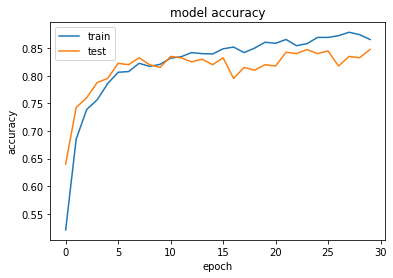

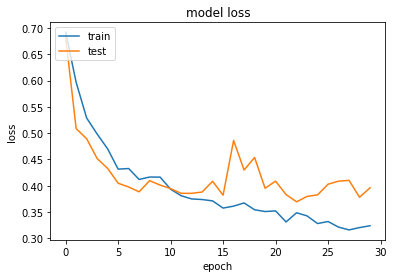

In [11]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save perfomance metrics

In [20]:
import os
import ipynbname
import json
# from keras.utils.layer_utils import count_params

current_directory = os.getcwd() + '/'
results_directory = current_directory.replace('notebooks', 'results_summary')

# experiment_name = ipynbname.name()
experiment_name = 'OpenPose\ no_back'

# Save history as json
with open(results_directory + experiment_name + '.json', 'w') as f:
    json.dump(history.history, f)
    
# Compute max val_accuracy and number of trainable params and append to stats
max_val_acc = max(history.history['val_accuracy'])
trainable_params = model.count_params()

# Store value in latex table format
acc_string = f'{experiment_name} & {max_val_acc:.2%}'.replace('%', '\%')
acc_params_string = acc_string + f' & {trainable_params}'

with open(results_directory + 'acc.dat', 'a') as f:
    f.write(acc_string + ' \\\ \n')
    
with open(results_directory + 'acc_params.dat', 'a') as f:
    f.write(acc_params_string + ' \\\ \n')

In [21]:
model.save(f'{experiment_name}.keras')